In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
# ************ numerical Model 1 ***************
def dfdx(state,currentLoc,vs=1):  # vs: ion speed at start of sheath
        phi = state[0]
        E = state[1]

        dphidx = -E
        dEdx = n_i(phi,vs)-n_e(phi)

        return [dphidx,dEdx]
    
def n_i(phi,vs):
        return 1/np.sqrt(1-2*phi/vs**2)
    
def vi(vs,phi,ns=1):
        return vs*ns/n_i(phi,vs)

def n_e(phi):
        return np.exp(phi)

def current(phi):
        mi_to_me = 1840
        return np.sqrt(mi_to_me/(2*np.pi))*np.exp(phi)-1

def Xwall(currentResult,x):
        searchValue = 0.0 #we are looking to find x where j=current=0
        xp, yp = np.flip(currentResult),np.flip(x)
        #both arrays flipped such that current increases as required by np.interp()
        xwall = np.interp(searchValue,xp,yp)
        return xwall
    
# ***** numerical Model 2 (incl. ion-neutrals collisions) ****
def dfdx2(state,currentLoc,L,vi0):  # vi0 passed through again as currentLoc not subscriptable
        phi, E, vi = state[0], state[1], state[2]

        dphidx = -E
        dEdx = n_i2(vi0,vi)-n_e(phi)
        dvidx = (E/vi)-(vi/L)
        return [dphidx,dEdx,dvidx]

def n_i2(vs,vi):
        return vs/vi
    
# ****** analytical model ***********
def phi_analytical(x,phiwall):
    return phiwall*np.exp(-np.absolute(x))

# ******* additional functions ******
def rho(vs,vi,phi):
    return n_i2(vs,vi)-n_e(phi)

def truncate(x,y):
    x2, y2 = [],[]
    for l,m in zip(x,y):
        if l <= 0.2:
            x2.append(l)
            y2.append(m)
    return x2,y2

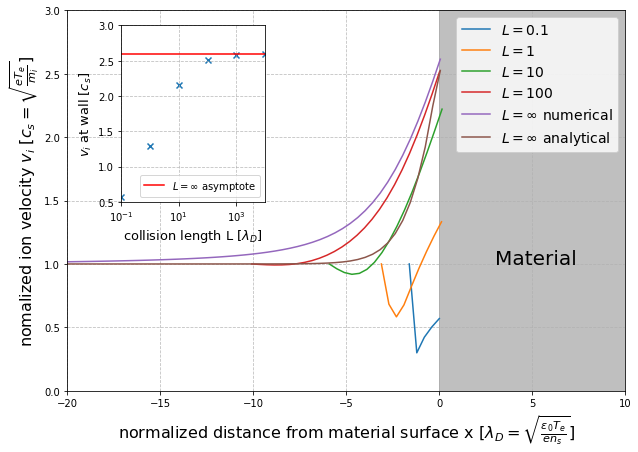

In [119]:
plt.figure(figsize=(10,7))

phi0, E0, vi0 = 0, 0.001, 1 #vi0 = vs = 1
initialState = [phi0,E0,vi0] #values at sheath-plasma boundary
x = np.linspace(0,40,100)
L = [0.1,1,10,100,1e3,1e4,"infinity-numerical","infinity-analytical"]

xshifts, viwall = np.zeros(len(L)), np.zeros(len(L))
results = np.zeros((len(L),len(x)), dtype={'names':('phi', 'current', 'rho','vi'),
                          'formats':('f8', 'f8', 'f8', 'f8')})


for i in range(len(L)):
    if L[i] != "infinity-analytical":
        if L[i] == "infinity-numerical":
            result = odeint(dfdx,[phi0,E0],x,args=(vi0,))
            results['phi'][i] = result[:,0]
            results['vi'][i] = vi(vi0,results['phi'][i])
            results['rho'][i] = rho(vi0,results['vi'][i],results['phi'][i])
        else:
            initialState = [phi0,E0,vi0]
            result = odeint(dfdx2,[phi0,E0,vi0],x,args=(L[i],vi0))
            results['phi'][i] = result[:,0]
            results['vi'][i] = result[:,2]
            results['rho'][i] = rho(vi0,results['vi'][i],results['phi'][i])

        results['current'][i] = current(results['phi'][i])
        xshifts[i] = Xwall(results['current'][i],x)
        viwall[i] = np.interp(xshifts[i],x,results['vi'][i]) #interpolate ion velocity to xwall
        phiWall = np.interp(xshifts[i],x,results['phi'][i]) #interpolate phi to xwall
        
        if L[i] == 1000 or L[i] == 10000:
            pass
        elif L[i] == "infinity-numerical":
            x2, vi2 = truncate(x-xshifts[i],results['vi'][i])
            plt.plot(x2,vi2,label=r"$L = \infty$ numerical")
        else:
            x2, vi2 = truncate(x-xshifts[i],results['vi'][i])
            plt.plot(x2,vi2,label=r"$L = $"+str(L[i]))

    else:
        results['phi'][i] = phi_analytical(x-xshifts[i-1],phiWall)
        results['vi'][i] = vi(vi0,results['phi'][i])
        results['rho'][i] = rho(vi0,results['vi'][i],results['phi'][i])
        results['current'][i] = current(results['phi'][i])
    
        x2, vi2 = truncate(x-xshifts[i-1],results['vi'][i])
        plt.plot(x2,vi2,label=r"$L = \infty$ analytical")
        
plt.xlabel(r"normalized distance from material surface x $[\lambda_D=\sqrt{\frac{\epsilon_0 T_e}{e n_s}}]$",fontsize=16)
plt.ylabel(r"nomalized ion velocity $v_i$ $ [c_s = \sqrt{\frac{eT_e}{m_i}}]$",fontsize=16)
plt.xlim(-20,10)
plt.ylim(0,3)
plt.axvspan(0, 20, alpha=0.5, color='grey')
plt.text(3,1,"Material",fontsize=20)
plt.legend(loc="upper right",fontsize=14)
plt.grid(ls="--",alpha=0.8)

ax = plt.axes([0.2, 0.5, 0.2, 0.35])
plt.scatter(L[:-2],viwall[:-2],marker="x")
plt.axhline(y=viwall[-2], color='r', linestyle='-',label=r"$L = \infty$ asymptote")
plt.xlabel(r"collision length L $[\lambda_D]$",fontsize=13)
plt.ylabel(r"$v_i$ at wall $[c_s]$",fontsize=13)
plt.xscale("log")
plt.xlim(L[0],L[-3])
plt.ylim(0.5,3)
plt.legend(loc="lower right",fontsize=10)
plt.grid(ls="--",alpha=0.8)

plt.show()

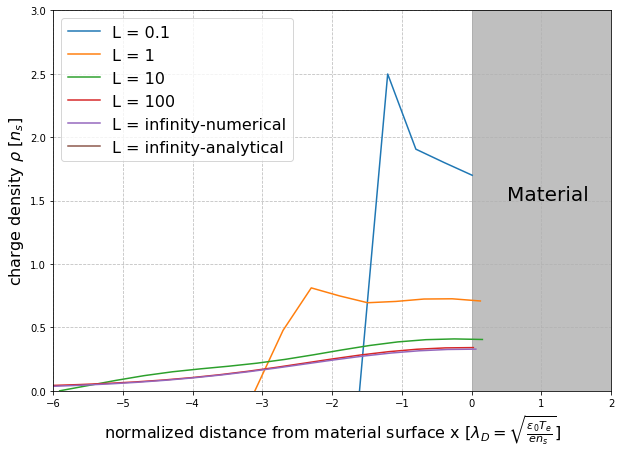

In [118]:
plt.figure(figsize=(10,7))

for j,k,l in zip(results['rho'],xshifts,L):
    if l != 1e3 and l != 1e4:
        x2, j2 = truncate(x-k,j)
        plt.plot(x2,j2,label="L = "+str(l))
    
plt.axvspan(0, 20, alpha=0.5, color='grey')
plt.text(0.5,1.5,"Material",fontsize=20)
plt.grid(ls="--",alpha=0.8)
plt.xlim(-6,2)
plt.ylim(0,3)
plt.xlabel(r"normalized distance from material surface x $[\lambda_D=\sqrt{\frac{\epsilon_0 T_e}{e n_s}}]$",fontsize=16)
plt.ylabel(r"charge density $\rho$ $[n_s]$",fontsize=16)
plt.legend(loc="upper left",fontsize=16)
plt.show()